In [ ]:
from sklearn.decomposition import DictionaryLearning
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from utils import JumpReLU, Step
import math
import pandas as pd
import re
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import os

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

## Loading

In [ ]:
# Load the 500m SAE model 
model = torch.load("ae.pt", map_location=torch.device('cpu'))
X = model["decoder.weight"].detach().numpy() # shape [1024, 8192], already normalized

# Load the annotation set
val_set = pd.read_csv('val_set_0_nt500_batchtopk_standard_results.csv')
latent_f1_pairs = val_set[['latent_id', 'best_f1_val0']]

# Create a mapping from latent_id to best_f1_val0
latent_to_f1 = dict(zip(val_set['latent_id'],
val_set['best_f1_val0']))

# Map each feature index to its F1 score (0 if not in val_set)
feature_indices = range(8192)
f1_scores = np.array([latent_to_f1.get(idx, 0.0) for idx in
feature_indices])

# Define some tensor for training
X_tensor = torch.tensor(X.T, dtype=torch.float32)
X_tensor_selected = X_tensor[f1_scores > 0] # train only on F1 positive features


## SAE class 

In [4]:
input_dim = X.shape[0]
base_lr = 2e-4
warmup_epochs_lr = 10
warmup_epochs_alpha = 1000
epochs = 5000
batch_size = 512
bandwidth = 0.01

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, bandwidth):
        super().__init__()
        self.bandwidth = bandwidth
        self.dtype = torch.float32
        self.latent_dim = latent_dim
        self.device = device
        self.initialize_weights()
        self.threshold = nn.Parameter(torch.tensor([0.001], dtype=torch.float32))

    def initialize_weights(self):
        # decoder bias
        self.b_dec = nn.Parameter(torch.zeros(input_dim, dtype=self.dtype, device=self.device))
        # decoder weights
        w_dec_data = torch.empty(self.latent_dim, input_dim, dtype=self.dtype, device=self.device)
        nn.init.kaiming_uniform_(w_dec_data)
        self.W_dec = nn.Parameter(w_dec_data)
        # encoder weights = tied transpose of decoder
        w_enc_data = self.W_dec.data.T.clone().detach().contiguous()
        self.W_enc = nn.Parameter(w_enc_data)

    def forward(self, x):
        hidden_pre = x @ self.W_enc
        z = JumpReLU.apply(hidden_pre, self.threshold, self.bandwidth)
        x_hat = z @ self.W_dec + self.b_dec
        return x_hat, hidden_pre, z


## Train across latent dimension and sparsity coef

In [20]:
sweep_results = []

for latent_dim_index in [0, 128]: # latent dimension 0 means random dictionary and d = 128
    for base_alpha in [0.019, 0.022, 0.025]: 

        if latent_dim_index == 0: 
            X_random = torch.randn_like(X_tensor_selected)
            X_random_normalized = X_random / X_random.norm(dim=1, keepdim=True)
            dataset = torch.utils.data.TensorDataset(X_random_normalized)
            latent_dim = 128
            base_alpha = base_alpha - 0.012
        else: 
            dataset = torch.utils.data.TensorDataset(X_tensor_selected)
            latent_dim = latent_dim_index
            
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        # base_alpha = base_alpha + (latent_dim-64)/12800.0 # useful for comparaison

        model = SparseAutoencoder(input_dim, latent_dim, bandwidth).to(device)
        optimizer = optim.Adam(model.parameters(), lr=base_lr)

        recons, losses, sparsities, real_l0s, lrs, alphas = [], [], [], [], [], []

        for epoch in range(epochs):
            warmup_factor_lr = min((epoch + 1) / warmup_epochs_lr, 1.0)
            warmup_factor_alpha = min((epoch + 1) / warmup_epochs_alpha, 1.0)
            lr = base_lr * warmup_factor_lr
            alpha = base_alpha * 0.5 * (1 - math.cos(math.pi * warmup_factor_alpha))
            for g in optimizer.param_groups:
                g['lr'] = lr

            total_loss, total_sparsity, total_recons, total_real_l0 = 0, 0, 0, 0
            for (x_batch,) in loader:
                x_batch = x_batch.to(device)
                x_hat, hidden_pre, z = model(x_batch)

                recon_loss = torch.sum((x_hat - x_batch) ** 2, dim=1).mean()
                l0 = torch.sum(Step.apply(hidden_pre, model.threshold, model.bandwidth), dim=-1)
                l0_loss = alpha * l0.mean()

                loss = recon_loss + l0_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # --- monitoring ---
                real_l0 = (torch.abs(z) > 0).float().sum(dim=1).mean().item()

                total_loss += loss.item()
                total_recons += recon_loss.item()
                total_sparsity += l0.mean().item()
                total_real_l0 += real_l0

            avg_loss = total_loss / len(loader)
            avg_recons = total_recons / len(loader)
            avg_sparsity = total_sparsity / len(loader)
            avg_real_l0 = total_real_l0 / len(loader)

            losses.append(avg_loss)
            recons.append(avg_recons)
            sparsities.append(avg_sparsity)
            real_l0s.append(avg_real_l0)
            lrs.append(lr)
            alphas.append(alpha)

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"[Dim={latent_dim_index}, α={base_alpha:.3f}] Epoch {epoch+1:04d} | "
                      f"Recon={avg_recons:.4f} | RealL0={avg_real_l0:.1f}")
        
        # Store final results
        sweep_results.append({
            'latent_dim': latent_dim_index,
            'alpha': base_alpha,
            'final_recon': recons[-1],
            'final_l0': real_l0s[-1]
        })

# Convert to DataFrame
results_df = pd.DataFrame(sweep_results)
print("\nSweep complete! Results summary:")
print(results_df)

[Dim=0, α=0.007] Epoch 0001 | Recon=1.0142 | RealL0=62.7
[Dim=0, α=0.007] Epoch 0101 | Recon=0.8385 | RealL0=61.9
[Dim=0, α=0.007] Epoch 0201 | Recon=0.7833 | RealL0=50.9
[Dim=0, α=0.007] Epoch 0301 | Recon=0.7596 | RealL0=41.6
[Dim=0, α=0.007] Epoch 0401 | Recon=0.7558 | RealL0=33.2
[Dim=0, α=0.007] Epoch 0501 | Recon=0.7594 | RealL0=26.6
[Dim=0, α=0.007] Epoch 0601 | Recon=0.7635 | RealL0=22.0
[Dim=0, α=0.007] Epoch 0701 | Recon=0.7647 | RealL0=19.4
[Dim=0, α=0.007] Epoch 0801 | Recon=0.7821 | RealL0=15.3
[Dim=0, α=0.007] Epoch 0901 | Recon=0.7748 | RealL0=14.9
[Dim=0, α=0.007] Epoch 1001 | Recon=0.7768 | RealL0=13.9
[Dim=0, α=0.007] Epoch 1101 | Recon=0.7769 | RealL0=13.1
[Dim=0, α=0.007] Epoch 1201 | Recon=0.7786 | RealL0=12.5
[Dim=0, α=0.007] Epoch 1301 | Recon=0.7795 | RealL0=12.0
[Dim=0, α=0.007] Epoch 1401 | Recon=0.7807 | RealL0=11.5
[Dim=0, α=0.007] Epoch 1501 | Recon=0.7811 | RealL0=11.2
[Dim=0, α=0.007] Epoch 1601 | Recon=0.7819 | RealL0=10.9
[Dim=0, α=0.007] Epoch 1701 | R

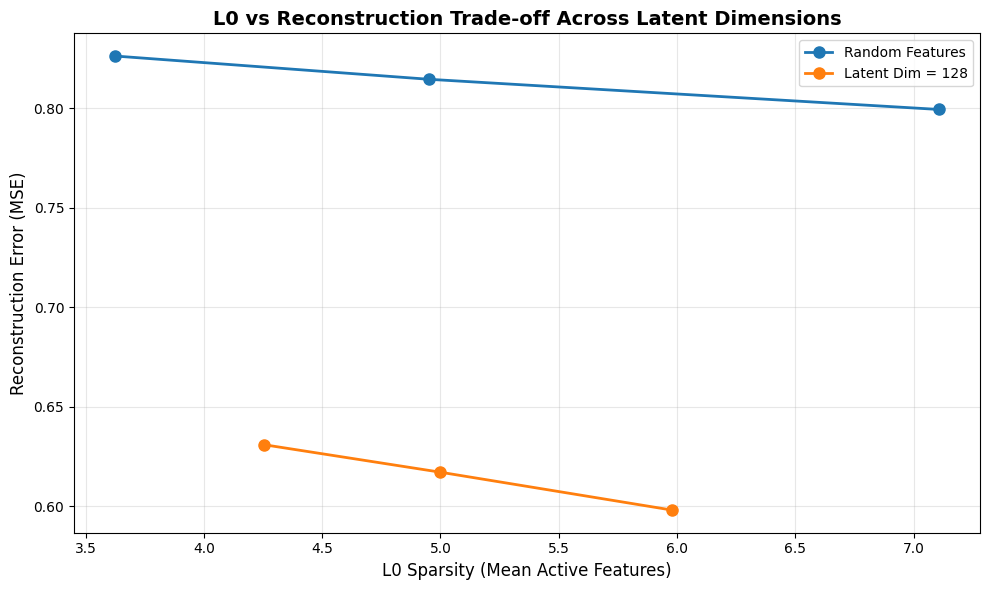

In [21]:
# Plot L0 vs Reconstruction for different latent dimensions
plt.figure(figsize=(10, 6))

# Pick 4 representative latent dimensions to plot
dims_to_plot = [0, 128]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for dim, color in zip(dims_to_plot, colors):
    subset = results_df[results_df['latent_dim'] == dim]
    plt.plot(subset['final_l0'], subset['final_recon'], 
             'o-', label=(f'Latent Dim = {dim}' if dim != 0 else 'Random Features'), 
             color=color, markersize=8, linewidth=2)

plt.xlabel('L0 Sparsity (Mean Active Features)', fontsize=12)
plt.ylabel('Reconstruction Error (MSE)', fontsize=12)
plt.title('L0 vs Reconstruction Trade-off Across Latent Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Saves excel file with meta-sae features (for the last trained model) and corresponding children annotations

In [ ]:
has_positive_f1 = f1_scores > 0
feature_indices = range(8192)
latent_to_annotation = dict(zip(val_set['latent_id'], val_set['annotation']))
annotations = [latent_to_annotation.get(idx) for idx in feature_indices if idx in latent_to_annotation]
items = [re.findall(r"'([^']+)'", s) for s in annotations]

Z = model(X_tensor[has_positive_f1].to('mps'))[2] > 0 

k = 20 # number of rows to show
values, indices = torch.topk(model(X_tensor[has_positive_f1].to("mps"))[2], k=k, dim=0)
mask = torch.zeros_like(Z, dtype=torch.bool)
mask.scatter_(0, indices, True)
Z_top10 = torch.where(mask, Z, torch.zeros_like(Z))

# Calculate importance score for each latent dimension
decoder_norms = model.W_dec.norm(dim=1).cpu() 
mean_activations = values.mean(dim=0).cpu()
importance_scores = (mean_activations * decoder_norms).detach().numpy()

min_score = importance_scores.min()
max_score = importance_scores.max()
normalized_scores = (importance_scores - min_score) / (max_score - min_score + 1e-10)
normalized_scores = np.clip(normalized_scores, 0.0, 0.4)  # Clip to [0, 1]
normalized_scores = normalized_scores / 0.4

N = Z_top10.shape[1]
all_columns = {}

for i in range(N):
    mask_col = Z_top10[:, i].cpu().numpy()
    selected = [x for x, m in zip(items, mask_col) if m]
    all_columns[f"Column_{i+1}"] = pd.Series(selected)

df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_columns.items()]))

# Save to Excel
output_file = f"meta_sae_annotations_D{latent_dim}_L0:{avg_real_l0:.0f}.xlsx"
df.to_excel(output_file, index=False)

wb = load_workbook(output_file)
ws = wb.active

for i in range(N):
    col_idx = i + 1  # Excel columns are 1-indexed
    score = normalized_scores[i]
    
    r = int(255 * (1 - score))
    g = int(255 * (1 - score))
    b = 255
    
    rgb = f"{r:02X}{g:02X}{b:02X}"
    fill = PatternFill(start_color=rgb, end_color=rgb, fill_type="solid")
    ws.cell(row=1, column=col_idx).fill = fill

# Save the colored workbook
wb.save(output_file)

torch.save(model.W_dec.detach().cpu(), f"meta_sae_decoder_weights_D{latent_dim}_L0:{avg_real_l0:.0f}.pt")

print(f"Saved colored Excel file to: {output_file}")
print(f"Importance score range: [{min_score:.4f}, {max_score:.4f}]")
print(f"Color scheme: White (low) → Blue (high, capped at 0.5)")


Saved colored Excel file to: meta_sae_annotations_D128_L0:4.xlsx
Importance score range: [0.3435, 0.7878]
Color scheme: White (low) → Blue (high, capped at 0.5)
